# Assignment
- download historical data (candles) for your chosen instrument or instruments, hourly time period or even more frequent,
- calculated the moving average value,
- make a decision on an order (enter the market, exit the market, do nothing), either in accordance with a mean-reverting strategy as discussed - during the class or another strategy, if you feel like doing so, you can use market orders and/or limit/stop orders,
- consider how stop loss / trailing stop loss fits into your strategy and implement it at will,
- make sure your strategy is set up in such a way that it will do some trading during a week, so we can look at the results together.

In [242]:
import dotenv
import requests
import json
import plotly.graph_objects as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Constants

In [243]:
API_KEY = dotenv.dotenv_values()['API_KEY']
HEADERS = {
    "Authorization": "Bearer {}".format(API_KEY),
    "Content-Type": "application/json; charset=utf-8"
}
INSTRUMENT = "BTC_USD"
BASE_URL = dotenv.dotenv_values()['BASE_URL']
GRANULARITY= "M5"
PERIOD= "280"
MOVING_AVERAGE_PERIOD = 6

# AccountManager Class

This class contains methods that allow to retrieve information about account.
It allows to:
- Get orders
- Get positions
- Get account details
- Create buy and sell orders

In [219]:
class AccountManager(object):
    
    __accountId = None

    def __init__(self):
        self.getAccountId()

    def getAccountId(self):
        if self.__accountId != None:
            return self.__accountId
        account = requests.get('{}accounts'.format(BASE_URL), headers=HEADERS).json()
        # TODO: Check if account exists
        self.__accountId = account['accounts'][0]['id']
        return self.__accountId

    def getAccountDetails(self):
        return requests.get('{}accounts/{}'.format(BASE_URL, self.getAccountId()), headers=HEADERS).json()
        
    def getOrders(self):
        return requests.get('{}accounts/{}/orders'.format(BASE_URL, self.getAccountId()), headers=HEADERS).json()

    def getPositions(self):
        return requests.get('{}accounts/{}/positions'.format(BASE_URL, self.getAccountId()), headers=HEADERS).json()

    def createOrder(self, type, instrument, price, units = 0.01):
        if type == "SELL" or type == "BUY":
            if type == "SELL":
                units = -units
            
            # TODO: Change limits to something more tangible. 1.03 and 0.98 are magic numbes
            takeProfit = round(price*1.03, 1)
            stopLoss = round(price*0.98, 1)

            # TODO: Decide which body should be used.

            # Create Stop Loss Take Profit Limit order
            body = {
                "order": {
                    "price": str(price),
                    "stopLossOnFill": {
                        "timeInForce": "GTC",
                        "price": str(stopLoss)
                    },
                    "takeProfitOnFill": {
                        "price": str(takeProfit),
                        "timeInForce": "GTC",
                    },
                    "instrument": instrument,
                    "units": units,
                    "type": "LIMIT",
                    "positionFill": "DEFAULT"
                }
            }
            # Create Fulfill or kill order
            # body = {
            #     "order": {
            #         "units": str(units),
            #         "instrument": instrument,
            #         "timeInForce": "FOK",
            #         "type": "MARKET",
            #         "positionFill": "DEFAULT"
            #     }
            # }
            body = json.dumps(body)     
            return requests.post("{}accounts/{}/orders".format(BASE_URL, self.getAccountId()), headers=HEADERS, data=body)



##### TODO: Create infinite loop that invokes getting latest state of selected Instrument
##### TODO: Based on selected strategy create buy and sell orders
##### TODO: Add more flexibility for given arguments into classes

In [220]:
acc_mananger = AccountManager()

In [225]:
# Buy Order
# acc_mananger.createOrder("BUY","BTC_USD", 46103.0, 0.02).json()

# Sell Order
# acc_mananger.createOrder("SELL","BTC_USD", 46103.0, 0.02).json()

# InstrumentHandler Class

- Inherits AccountManager class
- This class is strictly connected to Instrument only.
- It main purpose is to create dataframe that can be used for further usage.
- Additionaly can visualize Instruments candle plot. 

In [223]:
class InstrumentHandler(AccountManager): 
    __instrument = INSTRUMENT

    def __init__(self, instrument):
        self.__instrument = instrument
        self.data = pd.DataFrame()
        self.initializeInstrument()
        print("{} Initialized".format(instrument))
    
    def __getInstrument(self):
        url = '{}instruments/{}/candles?granularity={}&count={}'.format(BASE_URL, self.__instrument, GRANULARITY, PERIOD)
        return requests.get(url, headers=HEADERS).json()

    def __getInstrumentDataframe(self):
        for i, row in enumerate(list(self.__getInstrument()['candles'])):
            self.data.loc[i, 'time'] = pd.to_datetime(row['time'])
            self.data.loc[i, 'o'] = pd.to_numeric(row['mid']['o'])
            self.data.loc[i, 'h'] = pd.to_numeric(row['mid']['h'])
            self.data.loc[i, 'l'] = pd.to_numeric(row['mid']['l'])
            self.data.loc[i, 'c'] = pd.to_numeric(row['mid']['c'])
        self.data = self.data.set_index("time")

    def getInstrument(self):
        return self.__instrument

    def plotCandles(self):
        fig = go.Figure(
        data=[go.Ohlc(
                x=self.data.index,
                open=self.data['o'],
                high=self.data['h'],
                low=self.data['l'],
                close=self.data['c']
            ),
        ])
        fig.show()  
    

    def initializeInstrument(self):
        self.__getInstrumentDataframe()

# SimpleMovingAverage Class

- Extends InstrumentHandler class
- Improves candle plot with moving average line
- In this class we apply simple moving average algorithm onto collected data and apply logic to create orders according to signals

In [245]:
# Extend Base with Starategy class
class SimpleMovingAverage(InstrumentHandler):
    
    __percentile_distribution = []

    def __init__(self, instrument, **kwargs):
        super(SimpleMovingAverage, self).__init__(instrument, **kwargs)
        self.__getMovingAverage()
        self.__getPercentiles()
        self.__getSignals()

    # Private Methods
    def __getMovingAverage(self):
        self.data['returns'] = self.data['c'].diff()
        self.data['ma'] = self.data['c'].rolling(MOVING_AVERAGE_PERIOD).mean()
        self.data['ratio'] = self.data['c'] / self.data['ma']

    def __getPercentiles(self):
        # TODO: Get percentiles as argument
        percentiles = [5,10,50,90,95]
        self.__percentile_distribution = np.percentile(self.data['ratio'].dropna(), percentiles)

    def __getSignals(self):
        short = self.__percentile_distribution[-1] # 95th percentile - SELL
        long = self.__percentile_distribution[0] # 5th percentile - BUY
        self.data['position'] = np.where(self.data.ratio > short, -1, np.nan)
        self.data['position'] = np.where(self.data.ratio < long, 1, self.data['position'])
        self.data['position'] = self.data['position'].ffill()

    # Public methods

    def handleCurrentState(self):
        # TODO: Get latest data of instrument
        # TODO: Check signal for latest data state
        # TODO: Create order according to signal
        # TODO: ???
        # TODO: Profit
        return None

    def visualizePercentiles(self):
        self.data['ratio'].dropna().plot(legend=True)
        plt.axhline(self.__percentile_distribution[0], c = (.5,.5,.5), ls="--")
        plt.axhline(self.__percentile_distribution[2], c = (.5,.5,.5), ls="--")
        plt.axhline(self.__percentile_distribution[-1], c = (.5,.5,.5), ls="--")

    def visualizeSignals(self):
        self.data['position'].dropna().plot()
        
    def plotCandles(self):
        fig = go.Figure(
        data=[go.Ohlc(
                x=self.data.index,
                open=self.data['o'],
                high=self.data['h'],
                low=self.data['l'],
                close=self.data['c']
            ),
            go.Scatter(x=self.data.index, y=self.data['ma'], line=dict(color='blue', width=1)),
        ])
        fig.show()  
   

In [214]:
btc_usd_sma = SimpleMovingAverage(INSTRUMENT)
btc_usd_sma.data.head()


BTC_USD Initialized


,o,h,l,c,returns,ma,ratio,position
time,,,,,,,,
2021-12-16 22:40:00+00:00,47912.1,47938.4,47857.4,47883.5,NaN,NaN,NaN,NaN
2021-12-16 22:45:00+00:00,47883.6,47955.6,47868.4,47927.5,44.0,NaN,NaN,NaN
2021-12-16 22:50:00+00:00,47927.8,47929.2,47840.4,47853.6,-73.9,NaN,NaN,NaN
2021-12-16 22:55:00+00:00,47854.2,47950.9,47807.2,47817.2,-36.4,NaN,NaN,NaN
2021-12-16 23:00:00+00:00,47832.0,47832.0,47624.6,47638.0,-179.2,NaN,NaN,NaN


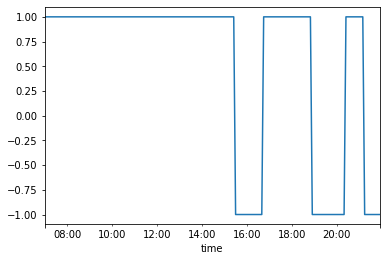

In [137]:
btc_usd_sma.visualizeSignals()

In [138]:
btc_usd_sma.plotCandles()

# Testing functional programming
## Not important
---

### Download data

In [67]:
def getInstrument():
    return requests.get('{}instruments/{}/candles?granularity={}&count={}'.format(BASE_URL, INSTRUMENT, GRANULARITY, PERIOD), headers=HEADERS).json()


### Put data into dataframe

In [68]:
data = pd.DataFrame()

for i, row in enumerate(list(getInstrument()['candles'])):
    data.loc[i, 'time'] = pd.to_datetime(row['time'])
    data.loc[i, 'o'] = pd.to_numeric(row['mid']['o'])
    data.loc[i, 'h'] = pd.to_numeric(row['mid']['h'])
    data.loc[i, 'l'] = pd.to_numeric(row['mid']['l'])
    data.loc[i, 'c'] = pd.to_numeric(row['mid']['c'])

data = data.set_index("time")

### Count Returns, moving average and ratio

In [69]:
data['returns'] = data['c'].diff()
data['ma'] = data['c'].rolling(MOVING_AVERAGE_PERIOD).mean()
data['ratio'] = data['c'] / data['ma']

### Select pricepoints
_Selected randomly_

In [72]:
percentiles = [5,10,50,90,95]
p = np.percentile(data['ratio'].dropna(), percentiles)

### Visualize percentiles

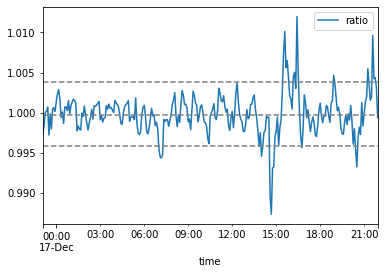

In [71]:
data['ratio'].dropna().plot(legend=True)
plt.axhline(p[0], c = (.5,.5,.5), ls="--")
plt.axhline(p[2], c = (.5,.5,.5), ls="--")
plt.axhline(p[-1], c = (.5,.5,.5), ls="--")

## Graph explanation
This graph displays at what percentiles should be the orders triggered. If price of Bitcoin is higher than 95th percentile, then we wan to sell it.
IF the price of Bitcoin is lower than 5th percentile, then we get the signal that it should be bought.
### 

### Get signal places to BUY and SELL

In [95]:
short = p[-1] # 95th percentile - SELL
long = p[0] # 5th percentile - BUY
data['position'] = np.where(data.ratio > short, -1, np.nan)
data['position'] = np.where(data.ratio < long, 1, data['position'])

data['position'] = data['position'].ffill()

In [96]:
data

,o,h,l,c,returns,ma,ratio,position
time,,,,,,,,
2021-12-16 22:40:00+00:00,47912.1,47938.4,47857.4,47883.5,NaN,NaN,NaN,NaN
2021-12-16 22:45:00+00:00,47883.6,47955.6,47868.4,47927.5,44.0,NaN,NaN,NaN
2021-12-16 22:50:00+00:00,47927.8,47929.2,47840.4,47853.6,-73.9,NaN,NaN,NaN
2021-12-16 22:55:00+00:00,47854.2,47950.9,47807.2,47817.2,-36.4,NaN,NaN,NaN
2021-12-16 23:00:00+00:00,47832.0,47832.0,47624.6,47638.0,-179.2,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-12-17 21:35:00+00:00,46602.2,47098.6,46590.8,47080.6,479.0,46631.750000,1.009625,-1.0
2021-12-17 21:40:00+00:00,47080.6,47096.0,46892.8,46916.9,-163.7,46719.533333,1.004224,-1.0
2021-12-17 21:45:00+00:00,46917.0,47013.0,46836.6,46984.4,67.5,46780.100000,1.004367,-1.0


### Visualize decisions

<AxesSubplot:xlabel='time'>

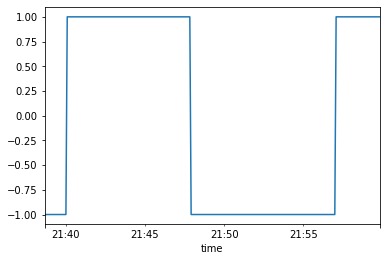

In [22]:
data['position'].dropna().plot()

### Plot BTC / USD price and moving average for selected period

In [24]:
fig = go.Figure(
    data=[go.Ohlc(
            x=data.index,
            open=data['o'],
            high=data['h'],
            low=data['l'],
            close=data['c']
        ),
        go.Scatter(x=data.index, y=data['ma'], line=dict(color='blue', width=1)),
    ])
fig.show()